# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

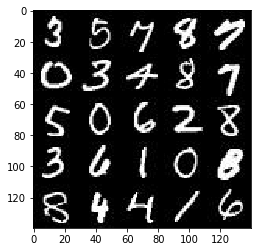

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

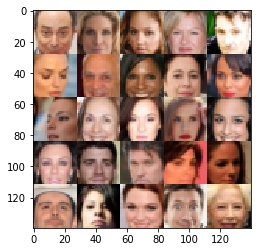

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name='real_input')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    #x = lambda x: tf.maximum(x * alpha, x)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input  28x28x3
        # 14x14x64 layer1
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer= kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        
        
        # 7x7x128 layer 2
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer= kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        
        
        # 4x4x256 layer 3
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer= kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        
        
        # Flatten
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Flatten layer 1 5*5*256
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        # conv2d layer 2 14*14*256
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)  
        
        # conv2d layer 3 28*28*128
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)  
        
        # logits  layer 4 28x28x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kernel_init, padding='same')
        
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
     # Real images from discriminator
    d_real_out, d_real_logits = discriminator(input_real,  reuse=False)
     # fake images from discriminator
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)
    
    #Discriminator real images loss
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    # Discriminator fake images loss
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))
    
    # Discriminator loss
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Trainable variables
    t_vars = tf.trainable_variables()
    
    # Trainable discriminator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Trainable generator variables
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        
        # Train optimizer for Discriminator
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        # Train optimizer for Generator
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Dim of picture w*h*color channels
    _, image_w, image_h, n_channels = data_shape
    
    # Model input
    input_real, input_z, lr = model_inputs(image_w, image_h, n_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, n_channels)
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                # Print progress
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5058... Generator Loss: 7.0502
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 2.0701
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 2.4116
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.3261
Epoch 1/2... Discriminator Loss: 0.9754... Generator Loss: 0.9642
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 1.3847
Epoch 1/2... Discriminator Loss: 1.7898... Generator Loss: 2.8997
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 1.4947
Epoch 1/2... Discriminator Loss: 1.6224... Generator Loss: 0.4664


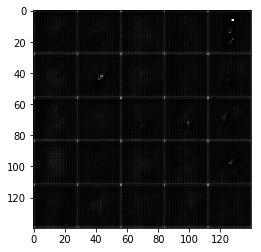

Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 1.6781
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.7729
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 2.2553
Epoch 1/2... Discriminator Loss: 2.3960... Generator Loss: 0.2617
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 1.1836
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 2.5081


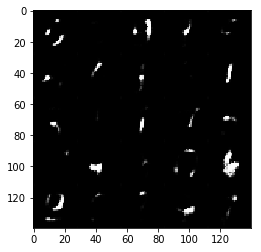

Epoch 1/2... Discriminator Loss: 1.8942... Generator Loss: 0.3449
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 2.3341
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 1.9018
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.0367
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 2.6769
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 1.9912
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 1.4162


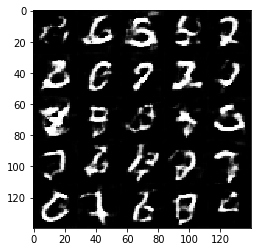

Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.7963
Epoch 1/2... Discriminator Loss: 2.2569... Generator Loss: 0.2695
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 1.4794
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 2.1232
Epoch 1/2... Discriminator Loss: 1.9086... Generator Loss: 0.3659
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.4569


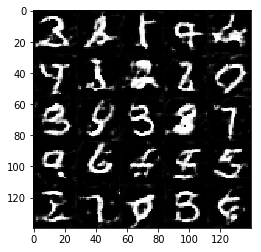

Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 1.6221... Generator Loss: 2.8466
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 2.1314
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 1.7378
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 2.1704
Epoch 1/2... Discriminator Loss: 1.8747... Generator Loss: 0.3259


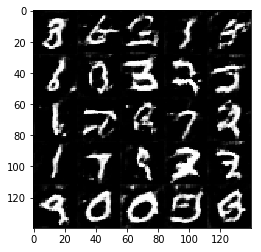

Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.8366
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 1.7725
Epoch 1/2... Discriminator Loss: 1.8623... Generator Loss: 0.3515
Epoch 1/2... Discriminator Loss: 1.8591... Generator Loss: 0.3563
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 2.1450... Generator Loss: 0.2261
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 0.8493


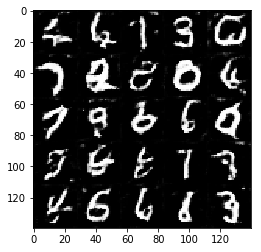

Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.0697
Epoch 1/2... Discriminator Loss: 1.7517... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 1.9641
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 1.1449
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.6003
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 1.3846
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.2962


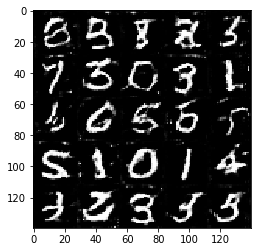

Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.6434
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.8098
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.1794
Epoch 1/2... Discriminator Loss: 1.5558... Generator Loss: 3.4529
Epoch 1/2... Discriminator Loss: 1.8314... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 1.7067... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.2920
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.4927
Epoch 1/2... Discriminator Loss: 1.7982... Generator Loss: 0.3859


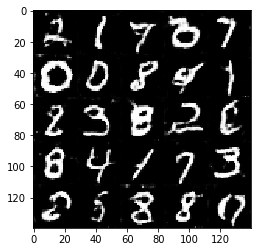

Epoch 1/2... Discriminator Loss: 1.8723... Generator Loss: 0.3343
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 1.2696
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.1529
Epoch 1/2... Discriminator Loss: 2.0764... Generator Loss: 0.2774
Epoch 1/2... Discriminator Loss: 1.5700... Generator Loss: 0.4080
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 2.7657
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.8212


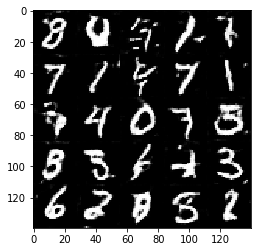

Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 2.9589
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 2.1319
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 1.8556
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.4517
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 2.5728
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 2.5922
Epoch 2/2... Discriminator Loss: 2.1661... Generator Loss: 0.3070
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.8126


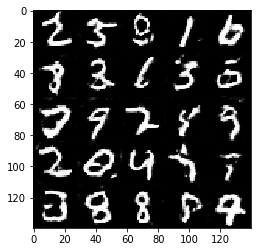

Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.5241
Epoch 2/2... Discriminator Loss: 1.0437... Generator Loss: 0.8659
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.1136
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 1.1993
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 2.1124... Generator Loss: 0.3541
Epoch 2/2... Discriminator Loss: 0.7697... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 2.3937... Generator Loss: 0.2117


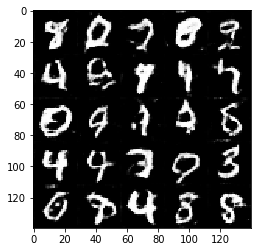

Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.3337
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 1.6058... Generator Loss: 0.4472
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 2.9935
Epoch 2/2... Discriminator Loss: 1.5623... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 1.6848... Generator Loss: 4.0512
Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 1.0543


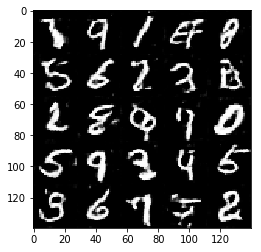

Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 2.3763
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.1651
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.5957
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.4757
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.4239
Epoch 2/2... Discriminator Loss: 1.8050... Generator Loss: 4.3490


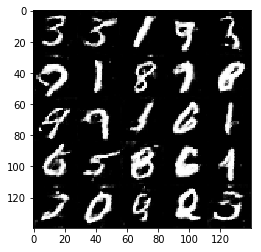

Epoch 2/2... Discriminator Loss: 2.0012... Generator Loss: 0.3381
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 1.1599
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 2.3127
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.5472
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 0.6712... Generator Loss: 1.6284
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 2.1140
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.9382
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.3122


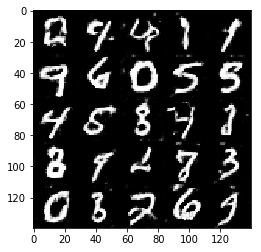

Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.0987
Epoch 2/2... Discriminator Loss: 1.8035... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.7045... Generator Loss: 0.4218
Epoch 2/2... Discriminator Loss: 2.3539... Generator Loss: 0.2185
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 2.6653
Epoch 2/2... Discriminator Loss: 1.8448... Generator Loss: 0.3310
Epoch 2/2... Discriminator Loss: 2.3533... Generator Loss: 0.2695
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 3.6843
Epoch 2/2... Discriminator Loss: 1.5946... Generator Loss: 0.4310


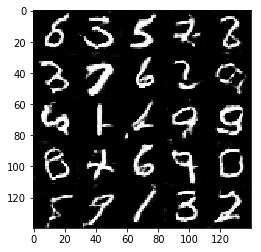

Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.8347
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.7998
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.5679
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.2793
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 1.5204
Epoch 2/2... Discriminator Loss: 1.6027... Generator Loss: 0.4185
Epoch 2/2... Discriminator Loss: 2.2031... Generator Loss: 4.0673
Epoch 2/2... Discriminator Loss: 2.5834... Generator Loss: 0.1598
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.6688


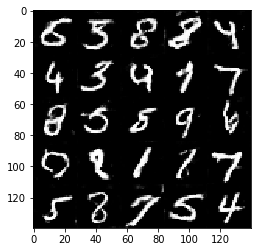

Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.6968... Generator Loss: 0.3591
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.3812
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 3.2296... Generator Loss: 0.1238
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.7006
Epoch 2/2... Discriminator Loss: 2.4070... Generator Loss: 0.2230
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 2.1643
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.5329


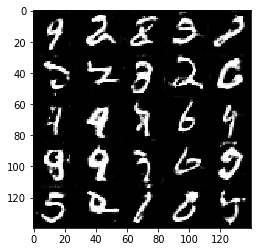

Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 3.5368... Generator Loss: 0.0727
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.8602... Generator Loss: 0.3711
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.6437
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.7901
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.1695
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.7852... Generator Loss: 3.9199
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.2713


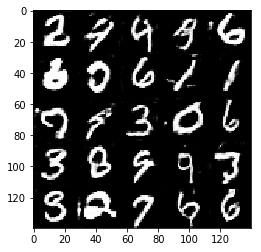

Epoch 2/2... Discriminator Loss: 1.4926... Generator Loss: 0.4849
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.2050
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.7338... Generator Loss: 0.3492
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.4808


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2297... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 2.6323
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 2.8391... Generator Loss: 0.1858
Epoch 1/1... Discriminator Loss: 2.0440... Generator Loss: 0.4008
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.3361


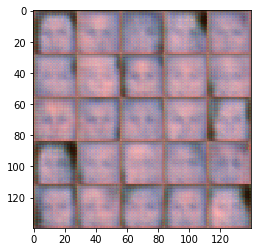

Epoch 1/1... Discriminator Loss: 1.7239... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.8187


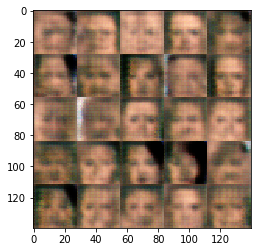

Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 1.8738
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 2.7672
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7197


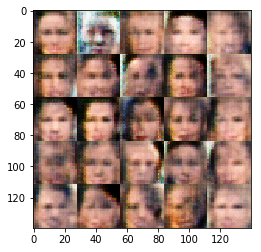

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 2.1804... Generator Loss: 0.2670
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8363


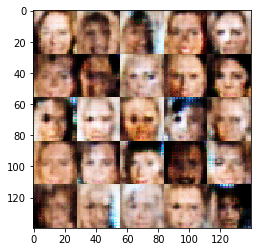

Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6082


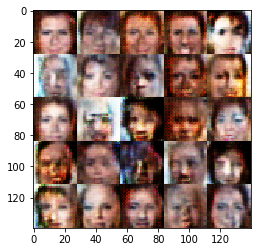

Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 1.0613


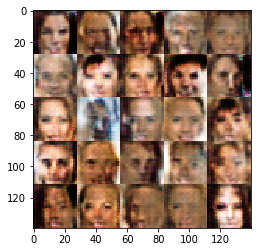

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5721


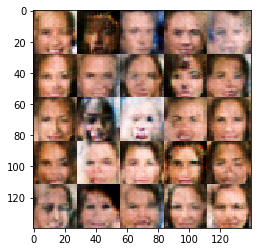

Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 1.0467


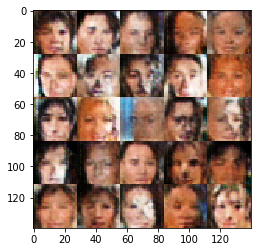

Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6806


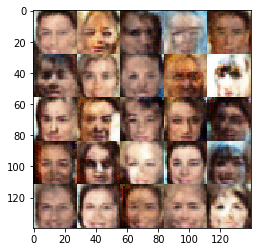

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.8810


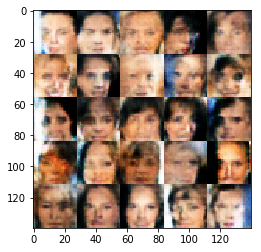

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7921


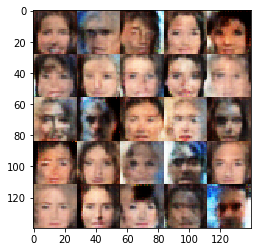

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.9817... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6093


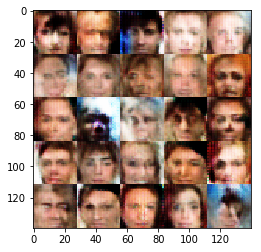

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8766


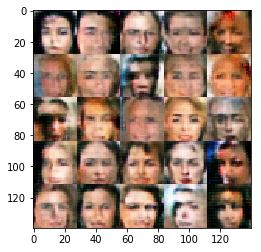

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7507


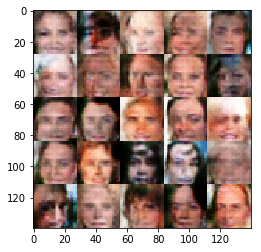

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 2.4404... Generator Loss: 0.2311
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.8115... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.6660


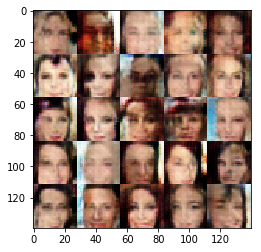

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 1.0584


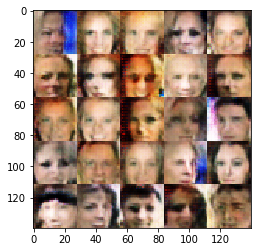

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.9447


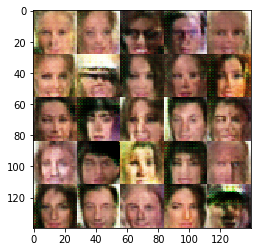

Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6350


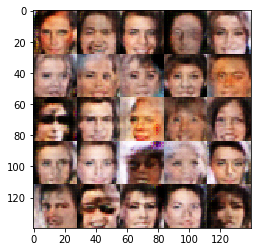

Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.1997
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7152


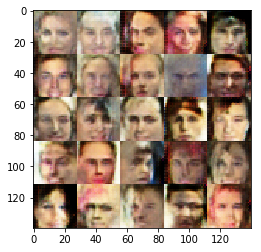

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.5689


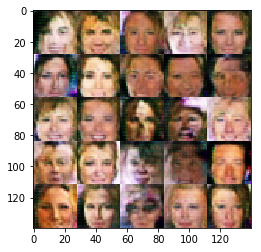

Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.2203


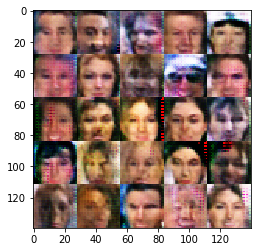

Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8974


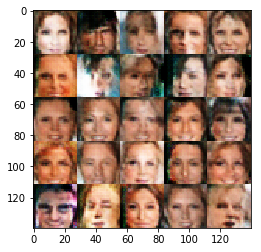

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5754


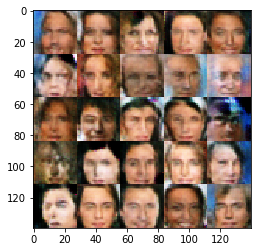

Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6527


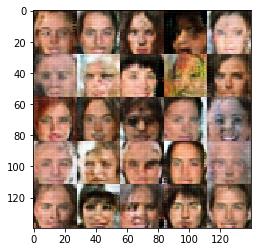

Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.2464


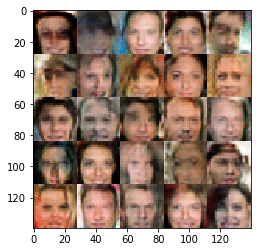

Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.7820


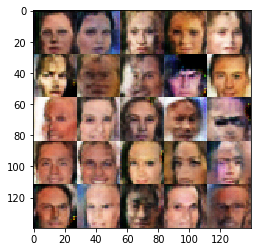

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.8421


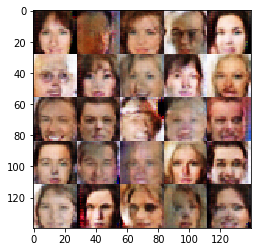

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.3072


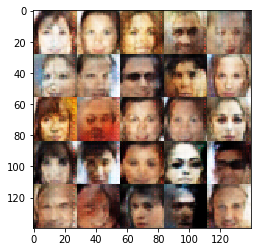

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.9419


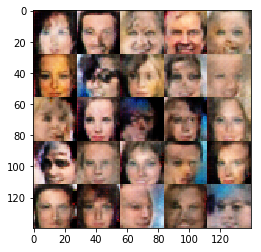

Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.5179


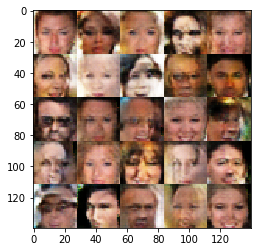

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5563


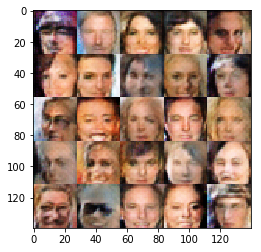

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6478


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.